In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

import os
import time
from typing import List

import pandas as pd
import numpy as np
import psycopg2

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan

# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [2]:
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)
    
    return None

def plot_global_embeddings_with_clusters(df: pd.DataFrame,
                          x_col: str,
                          y_col: str,
                          cluster_col: str,
                          title: str = "",
                          x_lim = None,
                          y_lim = None):
    """ Plots data colored by soft HDBSCAN clusters
    
    If the cluster of a compund is not specified (cluster < 0), it will be
    plotted gray, otherwise it will be colored by the cluster value.
    """
    clustered = df[cluster_col].values >= 0
    
    plt.figure(figsize=(10,8))
    ax=sns.scatterplot(data=df.iloc[~clustered],
                    x=x_col,
                    y=y_col,
                    color=(0.5, 0.5, 0.5),
                    s=10,
                    alpha=0.1)
    sns.scatterplot(data=df.iloc[clustered],
                    x=x_col,
                    y=y_col,
                    hue=cluster_col,
                    alpha=0.5,
                    palette="nipy_spectral",
                    ax=ax)
    if x_lim:
      ax.set_xlim(x_lim)
    if y_lim:
      ax.set_ylim(y_lim)

    sm = plt.cm.ScalarMappable(cmap="nipy_spectral")
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, label="Global Cluster")
  
    plt.title(title)
    plt.show()

In [4]:
# Read in data from MoleculeNet
#bbbp = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")
db_chem = psycopg2.connect(host = '10.2.0.140', dbname= 'chemistry', user="postgres", password="postgres")
# create a cursor
cur = db_chem.cursor()
sql = "select ss.smiles, count(ar.result_value),ss.structure_id from structure.structures ss \
join batch.batch_composition bc on bc.structure_id = ss.structure_id \
join batch.batches bb on bb.id_batch = bc.batch_id \
join assay.experiment ae on ae.batch_id = bb.id_batch \
join assay.result ar on ar.experiment_id = ae.id_experiment \
where ar.result_value != 0 \
group by ss.smiles, ss.structure_id"
#join structure.structure_properties sp on ss.structure_id = sp.structure_id \
#where sp.property_type_id = 15 and sp.property_value in ('7','8')
#,'10','11','12','13'
cur.execute(sql)
mollist=cur.fetchall()

# Clean up columnn names so they are easier to interpret
bbbp = pd.DataFrame(mollist,columns=["smiles", "permeable", "name"])
#bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()

#print(mollist)
print(bbbp)

                                               smiles  permeable    name
0           COc1ccc(CC(N)C(=O)Nc2ncc(C3(O)CCC3)s2)cc1          3   17052
1             Fc1ccc(Cl)cc1-c1nc(Nc2ccncc2)c2nccnc2n1          2   21111
2          O=C(Nc1ncc(C2(O)CCC2)s1)c1cc(-c2ccccc2)on1          1   17051
3         COc1cccc(-c2cc(NCc3ccc4c(c3)OCO4)nc(N)n2)c1          3   24697
4                    O=C(Nc1ncc(C2(O)CCC2)s1)c1ccccc1          2   17055
..                                                ...        ...     ...
56       O=C(Nc1ncc(C2(O)CCC2)s1)N1CCC(c2cnc[nH]2)CC1          2   17047
57  CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...          5   16557
58    Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)C2(F)F)c(=O)n1          4   17018
59  CCc1nc(C)cn2nc(-c3cc(=O)n4cc(C5CCN(C)CC5)cc(C)...          4      64
60  CO[C@H](C(=O)[C@@H](O)[C@@H](C)O)C1Cc2cc3cc(O[...          2  121829

[61 rows x 3 columns]


In [11]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

In [12]:
##### UMAP Embedding

#%%time
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(ecfp_descriptors)
bbbp["UMAP_0"], bbbp["UMAP_1"] = X_umap[:,0], X_umap[:,1]

##### PCA Embedding

#%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
bbbp["PCA_0"], bbbp["PCA_1"] = X_pca[:,0], X_pca[:,1]

##### tSNE Embedding

#%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
bbbp["TNSE_0"], bbbp["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]

C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\umap\umap_.py:1804: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\peter\anaconda3\envs\rdkit\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


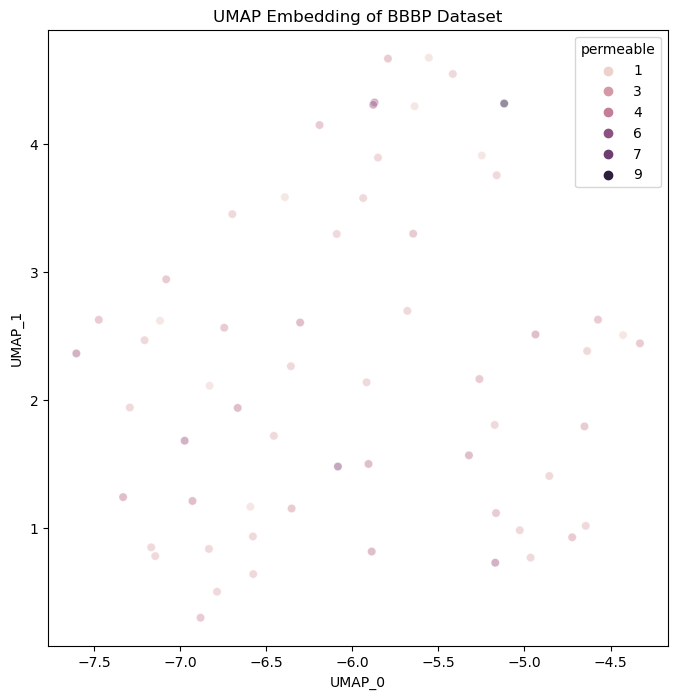

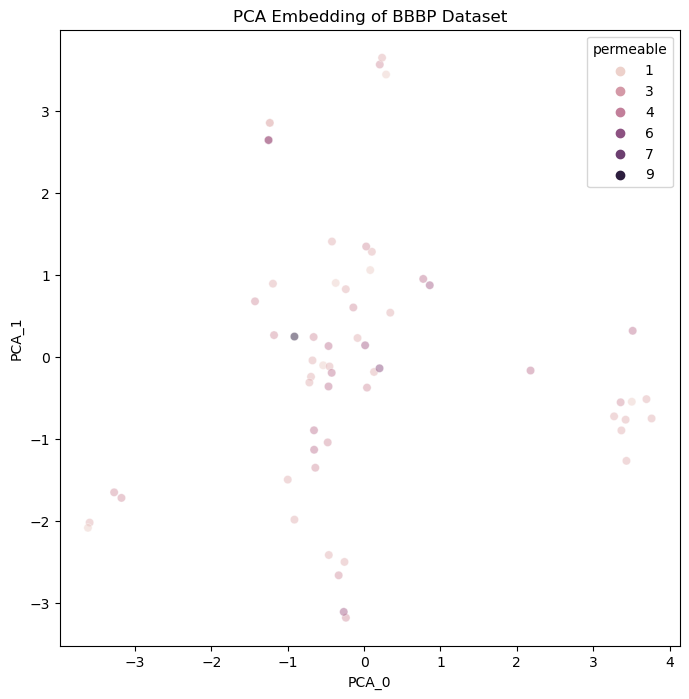

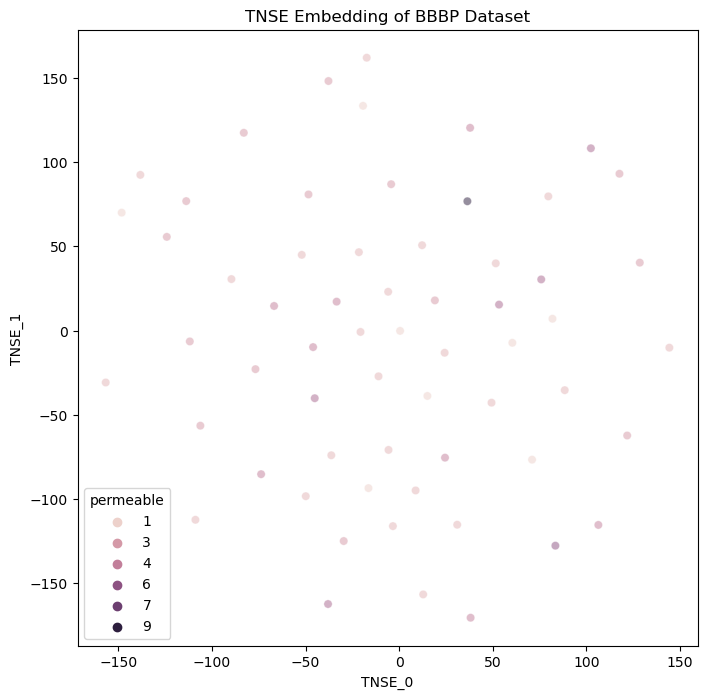

In [39]:
palette = sns.color_palette("Paired") #sns.color_palette(["hotpink", "dodgerblue"])
for method in ["UMAP", "PCA", "TNSE"]:
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=bbbp,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="permeable",
                    alpha=0.5)#,
                    #palette=palette)
    plt.title(f"{method} Embedding of BBBP Dataset")
    plt.show()


In [9]:
print(ecfp_descriptors)

[[0 1 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [13]:
print(bbbp)

                                               smiles  permeable    name  \
0           COc1ccc(CC(N)C(=O)Nc2ncc(C3(O)CCC3)s2)cc1          3   17052   
1             Fc1ccc(Cl)cc1-c1nc(Nc2ccncc2)c2nccnc2n1          2   21111   
2          O=C(Nc1ncc(C2(O)CCC2)s1)c1cc(-c2ccccc2)on1          1   17051   
3         COc1cccc(-c2cc(NCc3ccc4c(c3)OCO4)nc(N)n2)c1          3   24697   
4                    O=C(Nc1ncc(C2(O)CCC2)s1)c1ccccc1          2   17055   
..                                                ...        ...     ...   
56       O=C(Nc1ncc(C2(O)CCC2)s1)N1CCC(c2cnc[nH]2)CC1          2   17047   
57  CN[C@@H]1[C@@H](O)[C@@H](O[C@@H]2[C@@H](O)[C@H...          5   16557   
58    Nc1ccn([C@@H]2O[C@H](CO)[C@@H](O)C2(F)F)c(=O)n1          4   17018   
59  CCc1nc(C)cn2nc(-c3cc(=O)n4cc(C5CCN(C)CC5)cc(C)...          4      64   
60  CO[C@H](C(=O)[C@@H](O)[C@@H](C)O)C1Cc2cc3cc(O[...          2  121829   

       UMAP_0    UMAP_1     PCA_0     PCA_1     TNSE_0     TNSE_1  
0   14.256789  5.02